# Confounders and Covariates

## 6.1 Confounding

##### Example 6.3. Confounding by population structure

In [1]:
n = 1000 # individuals
p = 1000 # SNPs
u = runif(n, 0, 1) # coordinates of inds
d = runif(p, -0.5, +0.5) # allele frequency difference between T and K
tu = runif(p, 0.0, 0.5)  # when d>0 then tu is in (0, 0.5)
tu[d < 0] = 1 - tu[d < 0] # when d < 0 then tu is in (0.5, 1)
X = matrix(NA, nrow=n, ncol=p) # SNP data matrix, row individuals, columns SNPs
for(k in 1:p) {
    f = tu[k] + u * d[k] # allele 1 frequency for each individual
    X[, k] = rbinom(n, size=2, prob=f) # genotypes from varying frequcnies
}

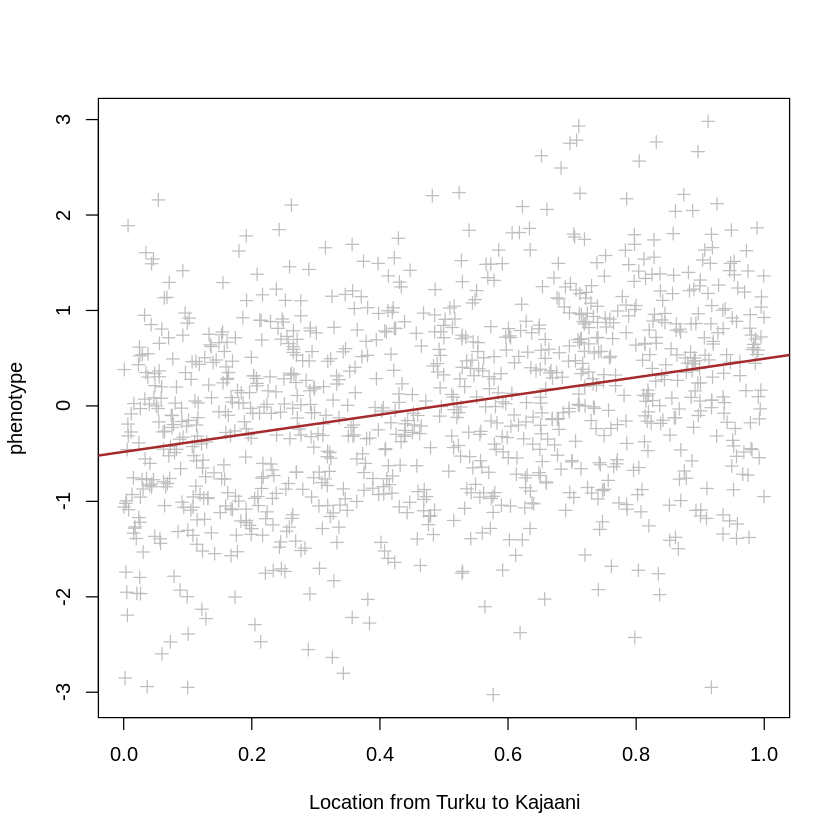

In [2]:
y = u + rnorm(n) # phenotype has a geographical cline but no genetic effect from X
y = scale(y) # standardize trait to have mean = 0 and var = 1 for convinience
# Check how it looks like
plot(u, y, xlab="Location from Turku to Kajaani", ylab="phenotype", pch=3, col="gray")
abline(lm(y ~ u), col="brown", lwd=2) # add reression line to plot

In [3]:
# Collect only P-values ie., element [2, 4] of lm's summary()
pval.1 = apply(X, 2, function(x){summary(lm(y ~ x))$coeff[2, 4]})
summary(pval.1) # median of P-values should be 0.5 under the null

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.003163 0.041605 0.199987 0.325353 0.991234 

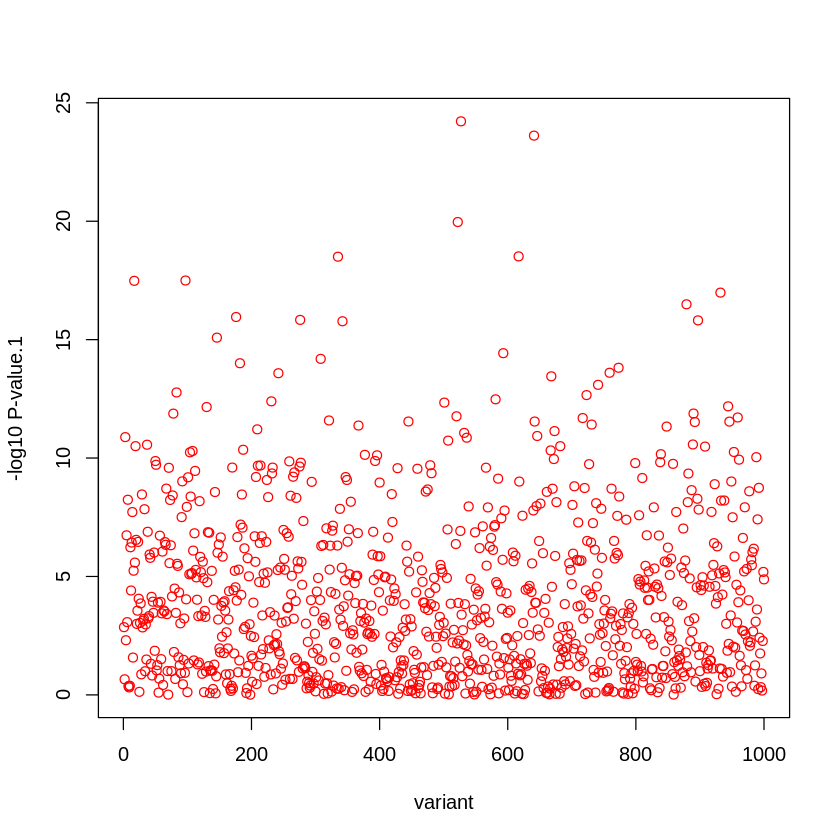

In [4]:
plot(1:p, -log(pval.1), xlab="variant", ylab="-log10 P-value.1", col="red")

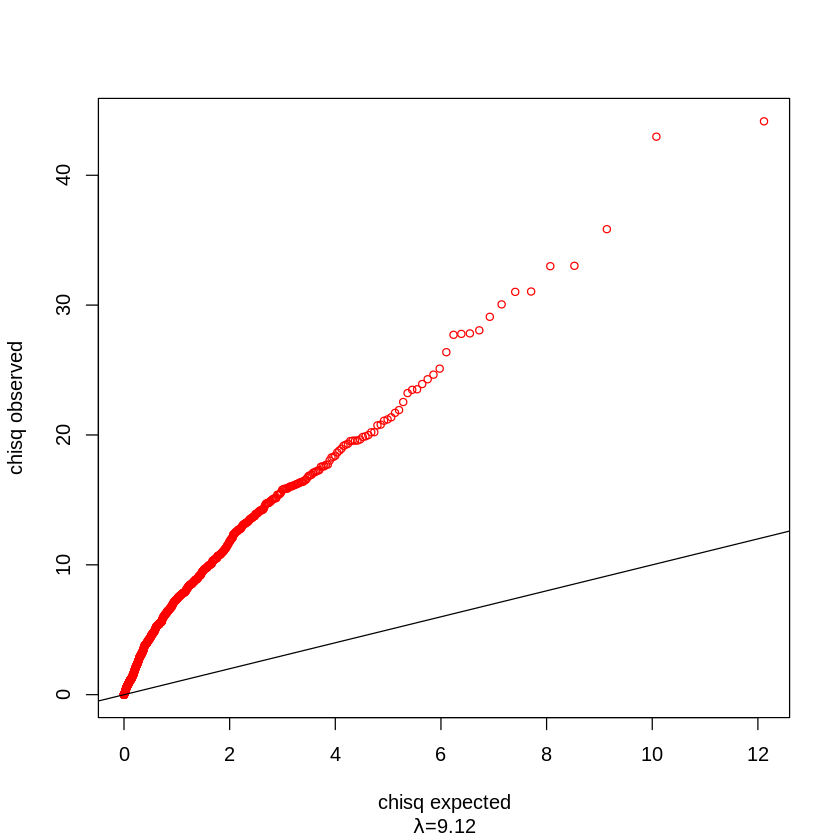

In [5]:
# Under NULL p-values are Uniformely distributed betwenn 0 and 1,
# hence chisq-stats are expected to be:
expect.stats = qchisq(ppoints(p), df=1, lower=F)
obs.stats = qchisq(pval.1, df=1, lower=F)
lambda = median(obs.stats) / median(expect.stats) # GC lambda = ratio of medians
qqplot(expect.stats, obs.stats, xlab="chisq expected", ylab="chisq observed",
       sub=substitute(paste(lambda, "=", lam), list(lam=signif(lambda, 3))),
       cex=0.8, col="red")
abline(0, 1)

In [6]:
snp.id = sample(1:p, size=1) # Randomly choose one SNP to have an effect

# We'll make this SNP explain about p.eff of the trait variance
p.eff = 0.015 # target variance explained
f.mean = tu[snp.id] + 0.50 * d[snp.id] # allele frequency at mid point
b = sqrt(p.eff / (2 * f.mean * (1 - f.mean))) # effect size corresp. to var explained = p.eff
y = scale(y + X[, snp.id] * b) # new trait is the old one added by the single SNP effect

In [7]:
pval.2 = apply(X, 2, function(x){summary(lm(y~x))$coeff[2, 4]})
summary(pval.2) # median sould be 0.50 under the null

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.007814 0.065996 0.222553 0.362380 0.995148 

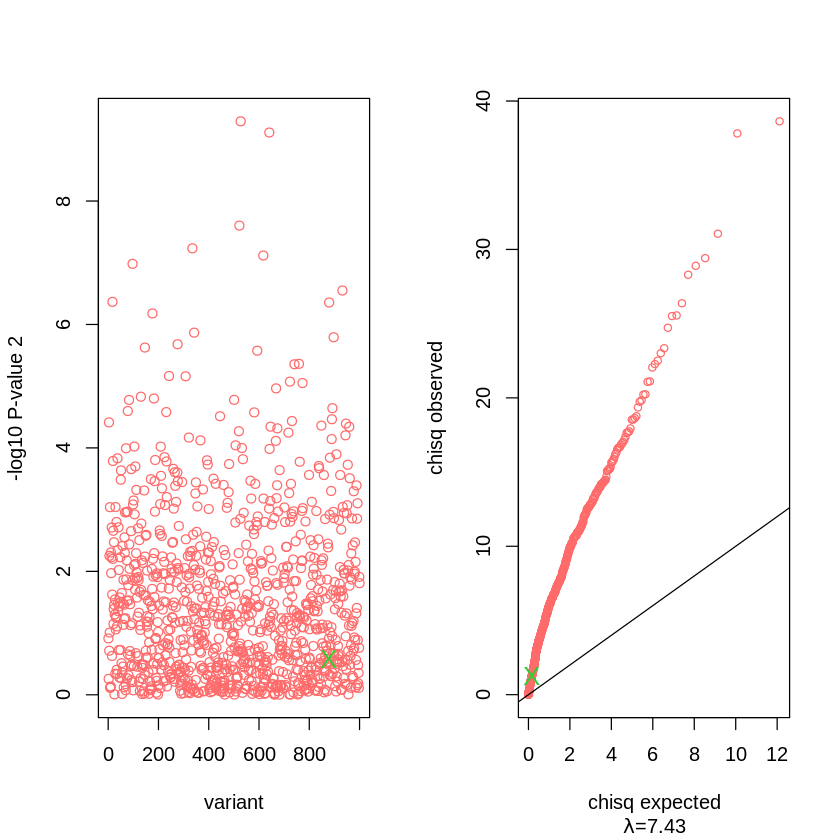

In [8]:
par(mfrow=c(1, 2))
plot(1:p, -log10(pval.2), xlab="variant",
     ylab="-log10 P-value 2", col="indianred1")
# Mark the effect on a green cross
points(snp.id, -log10(pval.2[snp.id]), pch="X", col="limegreen",cex=1.3)
# Make QQ-plot
obs.stats = qchisq(pval.2, df=1, lower=F)
lambda = median(obs.stats) / median(expect.stats) # GC lambda = ratio at medians
qqplot(expect.stats, obs.stats, xlab="chisq expected", ylab="chisq observed",
       sub=substitute(paste(lambda, "=", lam), list(lam=signif(lambda, 3))),
       cex=0.8, col="indianred1")
points(expect.stats[p + 1 - rank(obs.stats)[snp.id]],
       obs.stats[snp.id], pch="X", col="limegreen", cex=1.3)
abline(0, 1)

In [9]:
pval.3 = apply(X, 2, function(x){summary(lm(y ~ x + u))$coeff[2, 4]})
summary(pval.3) # median would be 0.5 under the null

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000876 0.261668 0.486499 0.501085 0.749806 0.999683 

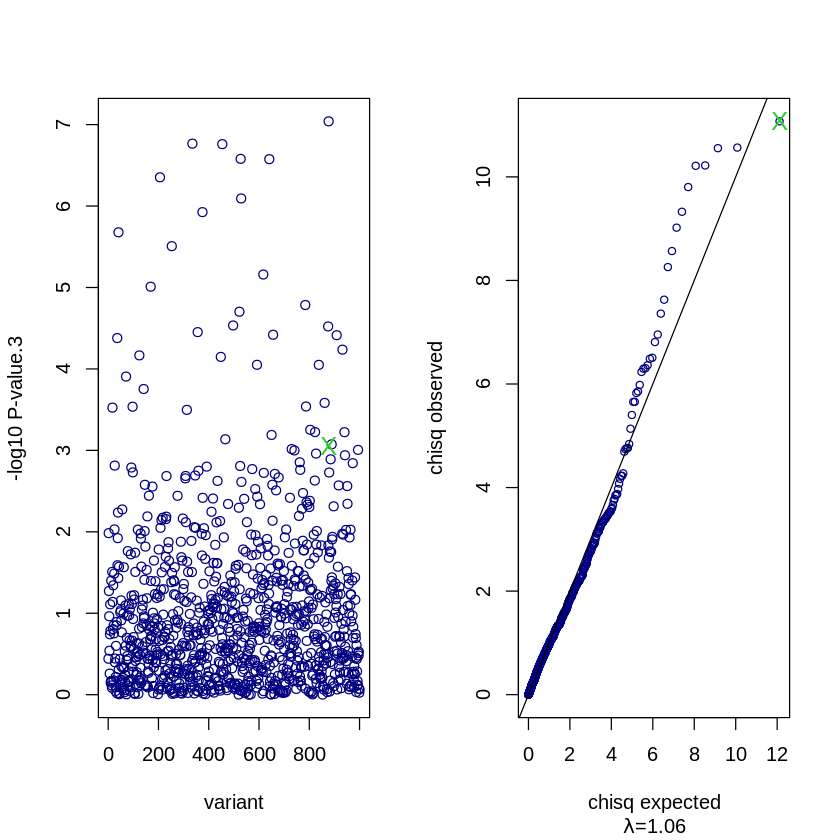

In [10]:
par(mfrow=c(1, 2))
plot(1:p, -log(pval.3), xlab="variant",
     ylab="-log10 P-value.3", col="navy")
# Mark the effect SNP by a green cross
points(snp.id, -log10(pval.3[snp.id]), pch="X", col="limegreen", cex=1.3)
# make QQ-plot
obs.stats = qchisq(pval.3, df=1, lower=F)
lambda = median(obs.stats) / median(expect.stats) # GC lambda = ratio at medians
qqplot(expect.stats, obs.stats, xlab="chisq expected", ylab="chisq observed",
                   sub=substitute(paste(lambda, "=", lam), list(lam=signif(lambda, 3))),
                   cex=0.8, col="navy")
points(expect.stats[p + 1 - rank(obs.stats)[snp.id]],
      obs.stats[snp.id], pch="X", col="limegreen", cex=1.3)
abline(0, 1)

In [11]:
pca = prcomp(X, scale. = T) # Make PCA
summary(lm(y ~ pca$x[, 1:10]))$coeff

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-1.941741e-17,0.030405543,-6.386142e-16,1.000000e+00
"pca$x[, 1:10]PC1",3.161917e-02,0.003823399,8.269911e+00,4.292368e-16
"pca$x[, 1:10]PC2",-2.130388e-02,0.015597051,-1.365892e+00,1.722835e-01
"pca$x[, 1:10]PC3",-1.483845e-02,0.015802496,-9.389941e-01,3.479630e-01
"pca$x[, 1:10]PC4",-4.203481e-02,0.015861812,-2.650063e+00,8.176128e-03
"pca$x[, 1:10]PC5",3.726441e-03,0.015909707,2.342244e-01,8.148593e-01
"pca$x[, 1:10]PC6",3.014785e-03,0.016011376,1.882902e-01,8.506878e-01
"pca$x[, 1:10]PC7",-7.583624e-03,0.016038168,-4.728485e-01,6.364256e-01
"pca$x[, 1:10]PC8",-4.739455e-02,0.016064997,-2.950175e+00,3.250782e-03
"pca$x[, 1:10]PC9",1.907396e-02,0.016197433,1.177592e+00,2.392427e-01


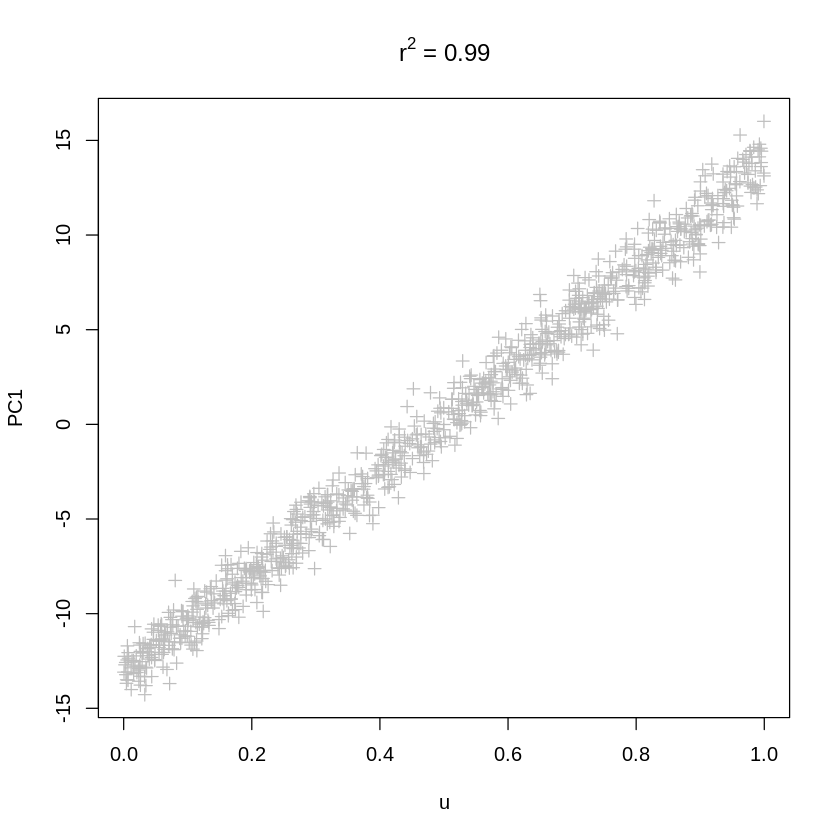

In [12]:
plot(u, pca$x[, 1], xlab="u", ylab="PC1", col="gray", pch=3,
     main=substitute(paste(r^2, " = ", r.val),
                    list(r.val = signif(cor(u, pca$x[, 1])^2, 2))))

## 6.2 Collider bias

In [13]:
f= 0.5 # MAF
N = 50000 # sample N males and N females from population
y = rep(c(0, 1), each=N) # "pheotype" = biological sex(0 = female, 1 = male)
x = rbinom(2*N, size=2, prob=f) # genotypes in males and females
summary(glm(y ~ x, family="binomial"))$coeff[2,]

Estimate   Std. Error      z value     Pr(>|z|) 
0.0002391461 0.0089283468 0.0267850401 0.9786311852

In [14]:
z = 164 + x*1 + 10*y # mean is 164, 165, 166 for females with genotype 0, 1, 2; and +10 for males
z = z + rnorm(2*N, 0, 5) # variation with SD=5cm around sex + genotype means for each individual
summary(glm(y ~ x + z, family="binomial"))$coeff[2:3, ]

,Estimate,Std. Error,z value,Pr(>|z|)
x,-0.4047707,0.013541790,-29.89048,2.61619e-196
z,0.3999394,0.002449845,163.25089,0.00000e+00


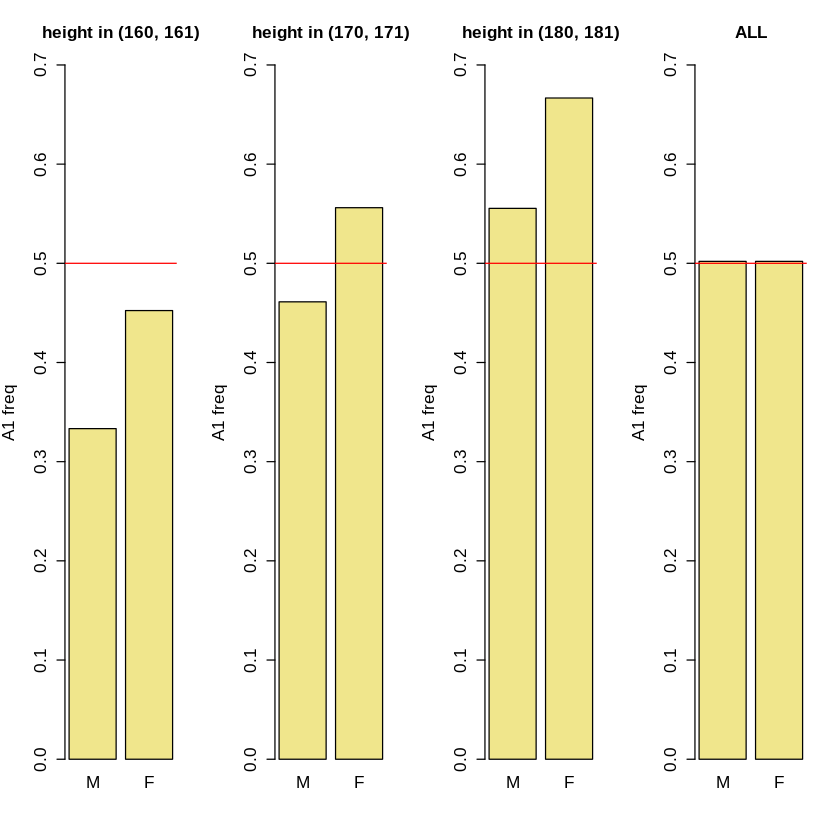

In [15]:
cut.points = matrix(c(160, 161, 170, 171, 180, 181),
                    byrow=T, ncol=2) # bins for height
par(mfrow=c(1, 4))
for(ii in 1:(1 + nrow(cut.points))) {
    if(ii <= nrow(cut.points)) { # this is a height stratified plot
        ind.m = (y == 1 & z > cut.points[ii, 1] & z <= cut.points[ii, 2]) # males
        ind.f = (y == 0 & z > cut.points[ii, 1] & z <= cut.points[ii, 2]) # females
        title.txt = paste0("height in (", cut.points[ii, 1], ", ", cut.points[ii, 2], ")")
    } else { # this last plot is for all individuals, independent of height
        ind.m = (y == 1) # males
        ind.f = (y == 1) # females
        title.txt = "ALL"
    }
    barplot(matrix(
        c(sum(x[ind.m])/2/sum(ind.m), # male allele 1 frequency
          sum(x[ind.f])/2/sum(ind.f)), ncol=2), # female allele 1 frequency
        ylim=c(0, 0.7), col="khaki", ylab="A1 freq",
        main=title.txt, cex.main=1.3, cex.lab=1.3, cex.axis=1.3, cex.names=1.3,
        names.arg=c("M", "F"))
    abline(h=0.50, col="red")
}

## 6.3 Mediation

In [16]:
n = 5e5 # large n to get accurate frequencies in BMI bins later
f = 0.50 # MAF
preval = 0.15 # population prevalance of T2D
mean.bmi = 27
x = replicate(2, rbinom(n, size=2, prob=f)) # genotypes at two variants
z = rnorm(n, mean.bmi, 3) + x[, 2] * 1 # BMI values in the sample affected by x2
log.odds = log(preval/(1-preval)) + (z - mean.bmi) * 0.15 + (x[,1] - 2*f) * 0.15
p.t2d = exp(log.odds) / (1 + exp(log.odds)) # probability of T2D for each individual
y = rbinom(n, size=1, prob=p.t2d)
table(y)/n

y
       0        1 
0.819406 0.180594 

In [17]:
# Let's do association test for the variants
summary(glm(y ~ x, family="binomial"))$coeff[2:3,]

,Estimate,Std. Error,z value,Pr(>|z|)
x1,0.1422275,0.005216653,27.26412,1.130269e-163
x2,0.1457592,0.005210593,27.97363,3.401770e-172


In [18]:
# Let's do association test for the variants by adjusting for BMI
summary(glm(y ~ x + z, family="binomial"))$coeff[2:4,]

,Estimate,Std. Error,z value,Pr(>|z|)
x1,1.457116e-01,0.005296557,27.510636466,1.309814e-166
x2,-1.870762e-05,0.005424713,-0.003448591,9.972484e-01
z,1.499207e-01,0.001282595,116.888519723,0.000000e+00


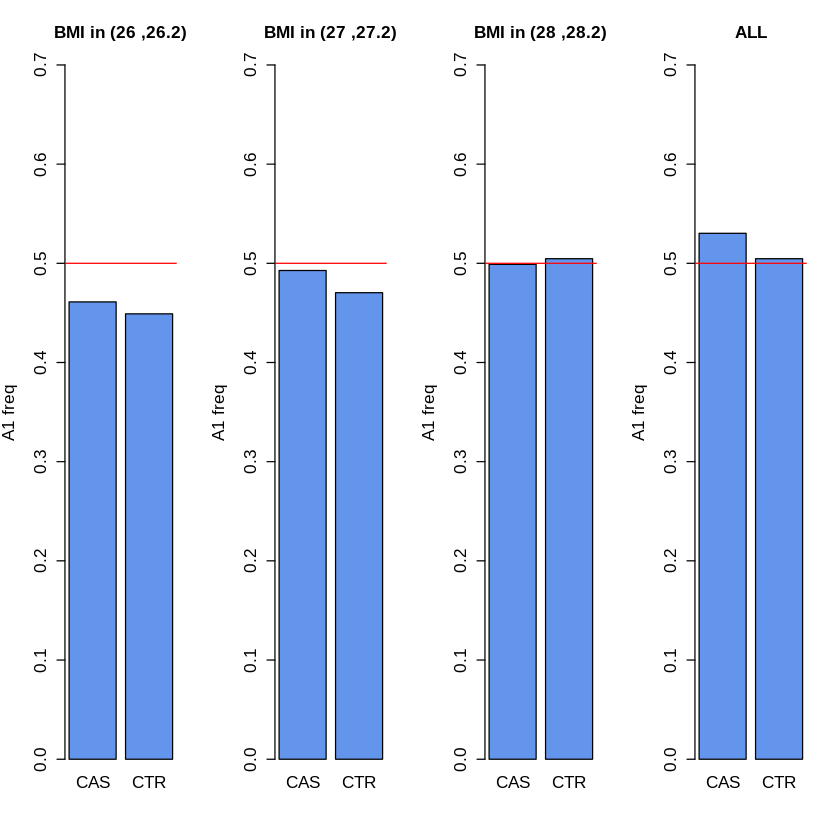

In [19]:
cut.points = matrix(c(26, 26.2,
                      27, 27.2,
                      28, 28.2),
                   byrow=T, ncol=2) # cutpoints
par(mfrow=c(1, 4))
for(ii in 1:(1 + nrow(cut.points))) {
    if(ii <= nrow(cut.points)) { # this is a BMI stratified plot
        ind.s = (y == 1 & z > cut.points[ii, 1] & z <= cut.points[ii, 2]) # cases
        ind.r = (y == 0 & z > cut.points[ii, 1] & z <= cut.points[ii, 2]) # controls
        title.txt = paste0("BMI in (", cut.points[ii, 1], " ,", cut.points[ii, 2], ")")
    } else {
        ind.s = (y == 1) # cases
        ind.f = (y == 0) # controls
        title.txt = "ALL"
    }
    barplot(matrix(
        c(sum(x[ind.s, 2]) / 2 / sum(ind.s), # case allele 1 frequency
          sum(x[ind.r, 2]) / 2 / sum(ind.r)), ncol=2), # control allele 1 frequency
        ylim = c(0, 0.7), col="cornflowerblue", ylab="A1 freq",
        main=title.txt, cex.main=1.3, cex.lab=1.3, cex.axis=1.3, cex.names=1.3,
        names.arg=c("CAS", "CTR")
    )
    abline(h=0.50, col="red")
}

## 6.4 Covariates independent of genetic variants in population samples

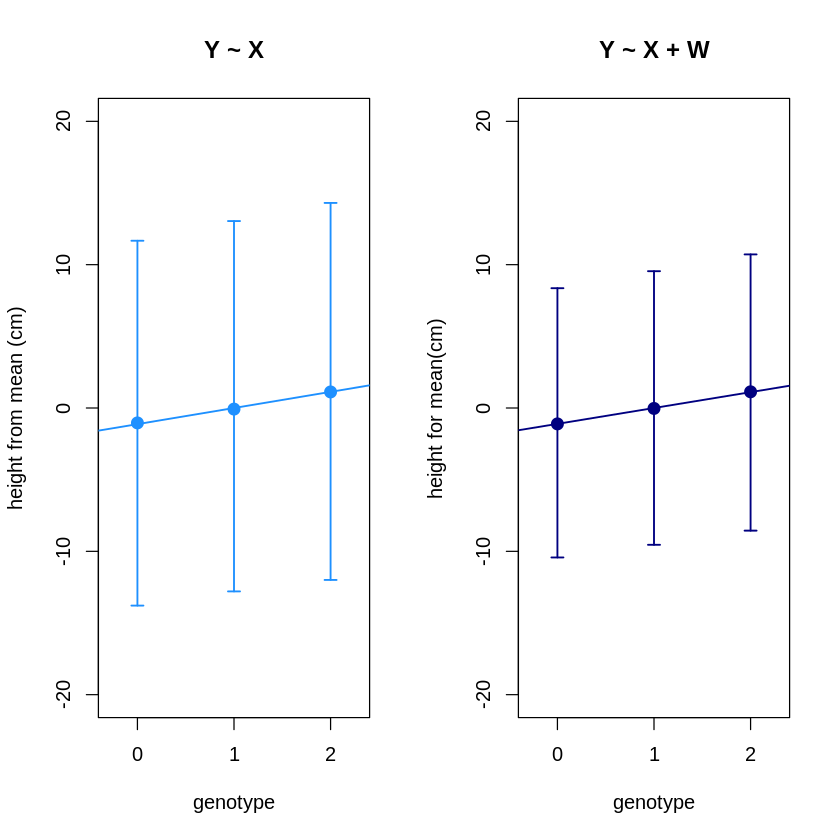

In [20]:
f = 0.50
b = 1
N = 1e4 # N males and N females
var.expl = 2 * f * (1-f) * b*2 # variance explained by SNP
w = rep(c(0, 1), each=N)
x = rbinom(2*N, size=2, p=f)
y = 164 + x * b + w * 10 # mean height 164, 165, 166 in geno 0, 1, 2 in females; +10 in males
y = y + rnorm(2*N, 0, sqrt(5^2 - var.expl)) # variation around mean height for each ind
y = y - mean(y) # mean center in population by shift of about -170

cols = c("dodgerblue", "navyblue")
par(mfrow=c(1, 2))
y.stat = matrix(NA, ncol=3, nrow=3)
for(ii in 0:2) {
    y.stat[ii+1, ] = as.numeric(quantile(y[x==ii], c(0.025, 0.50, 0.975)))
}
plot(0:2, y.stat[,2], col=cols[1], pch=19, cex=1.3,
     ylim=c(-20, 20), xlim=c(-0.3, 2.3), xaxt="n",
     xlab="genotype", ylab="height from mean (cm)", main="Y ~ X")
axis(1, at=0:2, labels=0:2)
arrows(0:2, y.stat[,1], 0:2, y.stat[,3], code=3, angle=90,
       lwd=1.5, length=0.05, col=cols[1])
lm.all = lm(y ~ x)
abline(lm.all, col=cols[1], lwd=1.5)

# Let's adjust the phenotype for sex
y.adj = residuals(lm(y ~ w)) # this substracts the sex specific mean from height
y.stat = matrix(NA, ncol=3, nrow=3)
for(ii in 0:2) {
    y.stat[ii+1, ] = as.numeric(quantile(y.adj[x==ii], c(0.025, 0.500, 0.975)))
}
plot(0:2, y.stat[,2], col=cols[2], pch=19, cex=1.3,
     ylim=c(-20, 20), xlim=c(-0.30, 2.30), xaxt="n", main="Y ~ X + W",
     xlab="genotype", ylab="height for mean(cm)")
axis(1, at=0:2, labels=0:2)
arrows(0:2, y.stat[,1], 0:2, y.stat[,3], code=3, angle=90,
       lwd=1.5, length=0.05, col=cols[2])
lm.adj = lm(y.adj ~ x)
abline(lm.adj, col=cols[2], lwd=1.5)

In [21]:
summary(lm.all)$coeff[2,] # unadjusted for W

Estimate   Std. Error      t value     Pr(>|t|) 
1.126195e+00 6.968163e-02 1.616201e+01 2.191447e-58

In [22]:
summary(lm.adj)$coeff[2,]

Estimate    Std. Error       t value      Pr(>|t|) 
 1.106212e+00  4.865985e-02  2.273357e+01 5.631378e-113

In [23]:
5 / sd(y)

[1] 0.7137845

In [24]:
summary(lm.adj)$coeff[2, 2] / summary(lm.all)$coeff[2, 2]

[1] 0.6983167

## 6.5 Covariates in ascertained case-control GWAS

In [25]:
source("https://www.mv.helsinki.fi/home/mjxpirin/log_regression_covariate_functions.R")
# Ankylosing Spondylitis with HLA-B27 as binary covariate X
K = 0.0025
freq.X = 0.08 # carriers of HLA-B27 in population
or.X = 49 # OR of B27 on AS risk
binary.covariate(K, freq.G=0.3, or.G=1.2, freq.X, or.X, ncases=2000, ncontrols=2000, population.controls=FALSE)

0.08461555,0.08702497,0.02237533
0.35259474,0.36104528,0.09234413
0.45171766,0.38715024,0.082951425
0.03841463,0.03277942,0.006986627


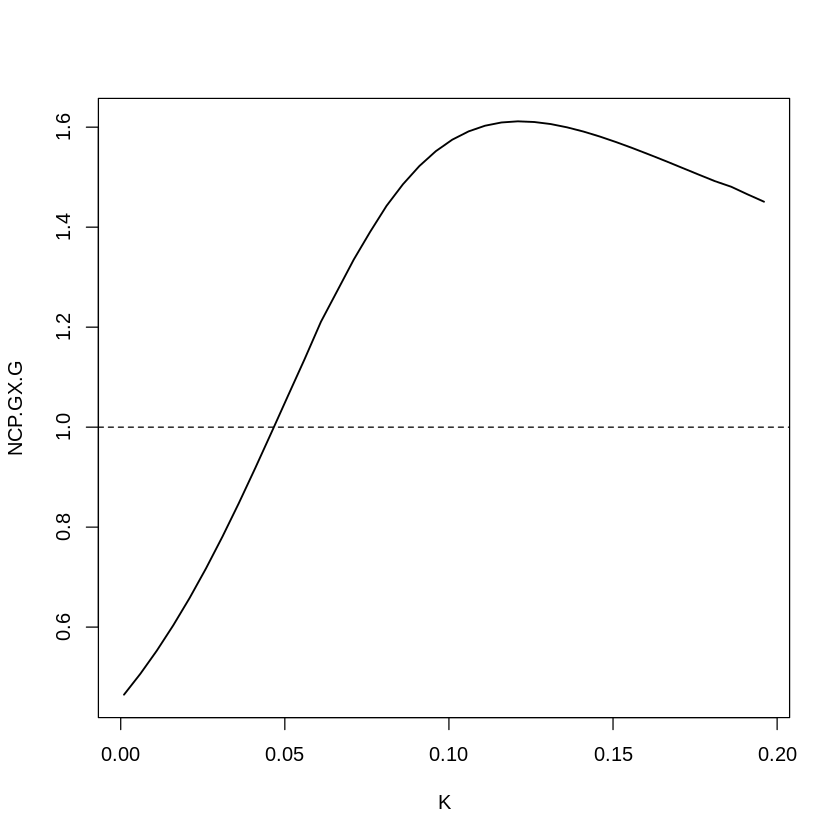

In [26]:
Ks = seq(0.001, 0.2, 0.005)
res = sapply(Ks, function(K){
    binary.covariate(K, freq.G=0.3, or.G=1.2, freq.X=0.08, 
                     or.X=49, ncases=2000, ncontrols=2000,
                    population.controls=FALSE)$NCP.GX.G
})
plot(Ks, res, type="l", xlab="K", ylab="NCP.GX.G", lwd=1.5)
abline(h=1, lty=2)